# Implementing the Decision Mamba from scratch. 
Evaluating on CartPole-v1 environment.
Inspired by original [Decision Transformer paper](https://arxiv.org/pdf/2106.01345.pdf) and [Mamba paper](https://arxiv.org/abs/2312.00752)

Pavel Nakaznenko, 2024

# Setup & Install

In [ ]:
!pip install gym tqdm numpy torch torchvision wandb

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import gym
import random
import numpy as np
from tqdm.auto import tqdm
import torch.nn.functional as F
import wandb
from torch.optim.lr_scheduler import OneCycleLR

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Prepare the dataset

In [3]:
def encode_one_hot(target_dim, num_dims):
    '''A helper function to one-hot encode agent's actions'''
    result = np.zeros(num_dims)
    result[target_dim] = 1
    return result

Decision Mamba requires a dataset of trajectories from an expert policy to train on.
There is a closeform solution for CartPole-v1, which always yields maximum reward. See here for more details:
https://towardsdatascience.com/how-to-beat-the-cartpole-game-in-5-lines-5ab4e738c93f

In [4]:
def theta_omega_policy_4_cart_pole(obs):
    '''Closeform solution for CartPole-v1'''
    theta, w = obs[2:4]
    if abs(theta) < 0.03:
        return 0 if w < 0 else 1
    else:
        return 0 if theta < 0 else 1

In [5]:
class EnvDataset(torch.utils.data.Dataset):
    '''Environment trajectories dataset'''
    def __init__(self, env, max_length, num_trajectories, goal):
        self.data = []
        self.max_length = max_length
        self.env = env

        # Collect trajectories
        pbar = tqdm(range(num_trajectories), desc="Generating trajectories", total=num_trajectories)
        while len(self.data)<num_trajectories:
            state = env.reset()
            trajectory = []
            total_reward = 0
            for t in range(max_length):
                action = theta_omega_policy_4_cart_pole(state)
                next_state, reward, done, _ = env.step(action)
                trajectory.append((state, action, reward))
                total_reward += reward
                state = next_state
                if done:
                    break
                    
            # Filter trajectories by total reward
            if total_reward >= goal:
                self.data.append(trajectory)
                pbar.update(1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        trajectory = self.data[idx]
        states, actions, rewards = zip(*trajectory)
        actions = [encode_one_hot(action, self.env.action_space.n) for action in actions]
        # Compute returns-to-go
        returns_to_go = np.cumsum(rewards[::-1])[::-1]

        return (returns_to_go, states, actions)

In [6]:
def process_sample(R, s, a, max_length):
    '''Helper function to properly stack and pad the trajectories'''
    pad_len_R = max_length - len(R)
    pad_len_s = max_length - len(s)
    pad_len_a = max_length - len(a)
    states = np.vstack((np.zeros((pad_len_s, len(s[0]))), s))
    actions = np.array([np.zeros(env.action_space.n)] * pad_len_a + list(a))
    returns_to_go = np.pad(np.array(R), (pad_len_R, 0), 'constant')
    mask = np.zeros(max_length)
    if pad_len_s > 0:
        mask[-pad_len_s:] = 1
    return (returns_to_go, states, actions, mask)

In [7]:
def collate_batch(batch):
    '''Collation function'''
    result = []

    max_length = max(len(sample[0]) for sample in batch)
    for sample in batch:
        returns_to_go, states, actions, mask = process_sample(sample[0], sample[1], sample[2], max_length)

        result.append((torch.FloatTensor(returns_to_go),
                       torch.FloatTensor(states),
                       torch.FloatTensor(actions),
                       torch.LongTensor(mask)))

    return zip(*result)

In [8]:
# Initialize environment
env_name = 'CartPole-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Create dataset
max_length = 200  # Maximum length of a sequence
max_return = 200  # Maximum cumulative reward possible
dataset_num = 15000 # Number of trajectories in dataset
dataset = EnvDataset(env, max_length=max_length, num_trajectories=dataset_num, goal=-1)

# Splitting dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Randomly split dataset into train and test datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for train and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_batch)

Generating trajectories:   0%|          | 0/15000 [00:00<?, ?it/s]

# Mamba model

In [9]:
class RMSNorm(nn.Module):
    def __init__(self, hidden_dim, eps=1e-8):
        super(RMSNorm, self).__init__()
        self.hidden_dim = hidden_dim
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(hidden_dim))

    def forward(self, x):
        """ 
        Input is a tensor of shape (batch_size, seq_length, hidden_dim)
        Output is the same tensor, but normalized
        Read about how and why it works here: https://arxiv.org/pdf/1910.07467.pdf
        """
        # calculate root mean square
        rms = torch.sqrt(torch.mean(x**2, dim=-1, keepdim=True) + self.eps)
        # normalize with learnable scale
        x = x / rms * self.scale
        return x

class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim: int, **kwargs):
        """Wrapper for a Mamba block with residual connection and RMSNorm"""
        super().__init__()
        self.mamba = MambaBlock(hidden_dim)
        self.norm = RMSNorm(hidden_dim)
        
    def forward(self, x):
        """
        Input is a tensor of shape (batch_size, seq_length, hidden_dim)
        Output is a tensor of the same size
        """
        # normalize
        output = self.norm(x)

        # pass through Mamba
        output = self.mamba(output)

        # add a residual connection
        output += x

        return output

class MambaBlock(nn.Module):
    def __init__(self, 
                        hidden_dim: int, # dimensionality of hidden representation
                        kernel_size: int = 128, # size of the convolutional kernel    
                        latent_state_dim: int = 64, # dimensionality of the latent state
                        E: int = 2, # expansion factor for hidden_dim, see section 3.4 of the paper
                        R: int = 48, # dimensionality for reparameterization, see section 3.6 of the paper    
                        
                        conv_bias: bool = True, # whether bias is needed for convolutional layers
                        proj_bias: bool = False, # whether bias is needed for projection layers
                 ):
        super().__init__()
        
        # expand the dimensionality of hidden representation (this is parameter D in the paper)
        self.hidden_dim_expanded = E * hidden_dim
        self.R = R
        self.latent_state_dim = latent_state_dim
        self.kernel_size = kernel_size
        
        # projection layer inside
        self.in_proj = nn.Linear(hidden_dim, self.hidden_dim_expanded * 2, bias=proj_bias)
        
        # convolutional layer
        self.conv1d = nn.Conv1d(
            in_channels=self.hidden_dim_expanded,
            out_channels=self.hidden_dim_expanded,
            bias=conv_bias,
            kernel_size=kernel_size,
            groups=self.hidden_dim_expanded,
            padding=kernel_size - 1,
        )

        # x_proj projects `x` and yields Δ, B, and C corresponding to the input
        self.x_proj = nn.Linear(self.hidden_dim_expanded, R + latent_state_dim * 2, bias=False)
        
        # dt_proj projects Δ from R to hidden_dim_expanded
        self.dt_proj = nn.Linear(R, self.hidden_dim_expanded, bias=True)

        # create a 1D tensor with values from 1 to latent_state_dim
        sequence = torch.arange(1, latent_state_dim + 1)
        # convert the sequence into a 2D tensor with hidden_dim_expanded rows of repetitions
        A = sequence.unsqueeze(0).repeat(self.hidden_dim_expanded, 1)
        
        self.A_log = nn.Parameter(torch.log(A))
        self.D = nn.Parameter(torch.ones(self.hidden_dim_expanded))
        self.out_proj = nn.Linear(self.hidden_dim_expanded, hidden_dim, bias=proj_bias)
        

    def forward(self, x):
        """
        Input is a tensor of shape (batch_size, seq_length, hidden_dim)
        Output is a tensor of the same size
        """
        (batch_size, seq_length, hidden_dim) = x.shape

        # project into x and residual parts 
        # (batch_size, seq_length, hidden_dim) -> (batch_size, seq_length, 2 * hidden_dim)
        x_and_residual = self.in_proj(x)
        
        (x, residual) = x_and_residual.split(split_size=[self.hidden_dim_expanded, self.hidden_dim_expanded], dim=-1)

        # swap dimensions of tensors (batch_size, seq_length, hidden_dim_expanded) -> (batch, hidden_dim_expanded, seq_length)
        x = x.permute(0, 2, 1)
        
        # apply convolution and trim to seq_length
        x = self.conv1d(x)[:, :, :seq_length]
        
        # swap dimensions back to the original order
        x = x.permute(0, 2, 1)

        # apply activation function
        x = F.silu(x)

        # apply ssm
        y = self.ssm(x)

        # mix with residual after activation 
        y = y * F.silu(residual)

        # project the output outward (batch_size, seq_length, hidden_dim_expanded) -> (batch_size, seq_length, hidden_dim)
        output = self.out_proj(y)

        return output

    
    def ssm(self, x):
        """
            Input is a tensor of shape (batch_size, seq_length, hidden_dim_expanded)
            Output is a tensor of the same size
        """
        # calculate state space parameters delta, A, B, C, and D
        #     A, D do not depend on input (see 3.5.2 "Interpretation of A" why)
        #     delta, B, C depend on input, which is the novelty of Mamba compared to time invariant S4,
        #                                  and that's why Mamba is called selective state spaces (S6)
        
        A = -torch.exp(self.A_log.float())  # shape (hidden_dim_expanded, latent_state_dim)
        D = self.D.float()

        # project and concatenate delta, B, C
        x_cat = self.x_proj(x)  # (batch_size, seq_length, R + 2*n)

        # split x_cat into
        # delta: (batch_size, seq_length, R)
        # B: (batch_size, seq_length, n)
        # C: (batch_size, seq_length, n)
        (delta, B, C) = x_cat.split(split_size=[self.R, self.latent_state_dim, self.latent_state_dim], dim=-1)  

        # project delta from R to hidden_dim_expanded
        # and activate with softplus
        # (batch_size, seq_length, hidden_dim_expanded)
        delta = F.softplus(self.dt_proj(delta))

        # now perform selective scan
        y = self.selective_scan(x, delta, A, B, C, D)
        
        return y

    
    def selective_scan(self, u, delta, A, B, C, D):
        """Implementation of the selective scan algorithm. See:
            - Section 2 State Space Models
            - Algorithm 2 in Section 3.2
            - run_SSM(A, B, C, u) in The Annotated S4 https://srush.github.io/annotated-s4/

        Classic discrete state space formula:
            x(t + 1) = Ax(t) + Bu(t)
            y(t)     = Cx(t) + Du(t)
        with the only difference being that B and C (as well as the step size delta used for discretization) depend on the input x(t).
    
        Inputs:
            u: shape (batch_size, seq_length, hidden_dim_expanded)
            delta: shape (batch_size, seq_length, hidden_dim_expanded)
            A: shape (hidden_dim_expanded, latent_state_dim)
            B: shape (batch_size, seq_length, latent_state_dim)
            C: shape (batch_size, seq_length, latent_state_dim)
            D: shape (hidden_dim_expanded,)
    
        Outputs:
            output: shape (batch_size, seq_length, hidden_dim_expanded)    
        """
        (batch_size, seq_length, hidden_dim_expanded) = u.shape
        
        # discretize continuous parameters A and B
        # - A is discretized using the zero-order hold (ZOH) method (https://en.wikipedia.org/wiki/Zero-order_hold)
        # - B is discretized using a simplified Euler discretization. As per the authors:
        #   "The A parameter is more important and the network works not significantly worse if we simplify the B parameter"
        deltaA = torch.exp(torch.einsum('b l d, d n -> b l d n', delta, A))
    
        # calculate delta * B * u for each time step
        deltaB_u = torch.einsum('b l d, b l n, b l d -> b l d n', delta, B, u)
    
        # initialize states x and a list to store output values y
        x = torch.zeros((batch_size, hidden_dim_expanded, self.latent_state_dim), device=deltaA.device)
        ys = []
    
        # iterate through the entire sequence
        for i in range(seq_length):
            # update state x using current deltaA and deltaB_u values
            x = deltaA[:, i] * x + deltaB_u[:, i]
    
            # compute the output value y at the current time step
            y = torch.einsum('b d n, b n -> b d', x, C[:, i, :])
    
            # add the current y value to the list
            ys.append(y)
    
        # stack all the output values y into one tensor
        y = torch.stack(ys, dim=1)
    
        # add the influence of the input signal u, multiplied by D, to each element of the output tensor y
        y = y + u * D
    
        return y

Because we're going to have our own embeddings strategy, we get rid of mamba's positional encoding and head

In [10]:
class Mamba_EmbeddingsOnly(nn.Module):
    def __init__(self,
                        hidden_dim: int, # dimensionality of the hidden representation
                        num_layers: int, # number of layers
):
        super().__init__()

        # normalization layer
        self.norm = RMSNorm(hidden_dim)

        # Mamba layers with residual connections
        self.mamba_layers = nn.ModuleList([ResidualBlock(hidden_dim) for _ in range(num_layers)])

    def forward(self, input_embeds):
        x = input_embeds
        # pass through Mamba layers
        for layer in self.mamba_layers:
            x = layer(x)

        # normalize
        x = self.norm(x)

        return x

# Decision Mamba model

In [11]:
class EmbeddingLayer(nn.Module):
    """Custom simple embedding layer with positional embedding encoding"""
    def __init__(self, input_dim, embed_dim):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)

    def forward(self, x, pos_embedding):
        return self.embedding(x) + pos_embedding

class DecisionMamba(nn.Module):
    def __init__(self, state_dim, action_dim, max_length, embed_dim, num_layers, dim_feedforward = 2048):
        super().__init__()
        self.embed_dim = embed_dim # embedding dimension
        self.embed_s = EmbeddingLayer(state_dim, embed_dim) # for states
        self.embed_a = EmbeddingLayer(action_dim, embed_dim) # for actions
        self.embed_R = EmbeddingLayer(1, embed_dim)  # returns-to-go is 1D
        self.embed_t = nn.Embedding(max_length, embed_dim) # for timestep
        self.embed_ln = nn.LayerNorm(embed_dim)

        # use Mamba backbone which takes and outputs only embeddings
        self.mamba = Mamba_EmbeddingsOnly(hidden_dim = embed_dim, num_layers = num_layers)
        self.pred_a = nn.Linear(embed_dim, action_dim)
        self.max_length = max_length

    def forward(self, R, s, a, t, mask = None):
        #print(f"{R.shape=}, {s.shape=}, {a.shape=}, {t.shape=}")
        # Compute embeddings for tokens
        pos_embedding = self.embed_t(t)
        s_embedding = self.embed_s(s, pos_embedding)
        a_embedding = self.embed_a(a, pos_embedding)
        R_embedding = self.embed_R(R, pos_embedding)

        # Interleave embeddings as R1,s1,a1,R2,s2,a2,... etc
        input_embeds = torch.stack((R_embedding, s_embedding, a_embedding), dim=1).permute(0, 2, 1, 3).reshape(s.size(0), 3*s.size(1), self.embed_dim)
        input_embeds = self.embed_ln(input_embeds)

        # Use mamba to get hidden states
        hidden_states = self.mamba(input_embeds)

        # Get hidden states representations such that
        # hidden_states[:, 0, t] is a hidden state after attending [sequence,r_t]
        # hidden_states[:, 1, t] is a hidden state after attending [sequence,r_t,s_t]
        # hidden_states[:, 2, t] is a hidden state after attending [sequence,r_t,s_t,a_t]
        hidden_states = hidden_states.reshape(s.size(0), s.size(1), 3, self.embed_dim).permute(0, 2, 1, 3)

        # We care about actions only
        a_hidden = hidden_states[:, 1, :]

        # Predict action
        return self.pred_a(a_hidden)

# Train, validation, eval functions

In [12]:
def evaluate_model(model, env, max_length, target_return):
    model.eval()
    state = env.reset()
    done = False
    total_reward = 0
    R = [target_return]
    s, a = [state], [encode_one_hot(0, env.action_space.n)]
    timesteps = np.arange(max_length)
    with torch.no_grad():
        while not done and len(s) < max_length:
            returns_to_go, states, actions, mask = process_sample(R, s, a, len(s))
            returns_to_go_tensor = torch.tensor(returns_to_go, dtype=torch.float).unsqueeze(0).unsqueeze(-1).to(DEVICE)
            states_tensor = torch.tensor(states, dtype=torch.float).unsqueeze(0).to(DEVICE)
            actions_tensor = torch.tensor(actions, dtype=torch.float).unsqueeze(0).to(DEVICE)
            timesteps_tensor = torch.tensor(timesteps, dtype=torch.long)[:len(s)].unsqueeze(0).to(DEVICE)
            mask_tensor = torch.tensor(mask, dtype=torch.long).unsqueeze(0).to(DEVICE)

            action = model(returns_to_go_tensor / target_return,
                           states_tensor,
                           actions_tensor,
                           timesteps_tensor,
                           mask_tensor)

            # Remove batch dim and take the hidden output for the last predicted action
            action = action.squeeze(0)[-1]
            # Most likely action to be taken
            action = torch.argmax(torch.softmax(action, dim=-1))
            action = action.cpu().detach().item()
            state, reward, done, _ = env.step(action)
            total_reward += reward

            # Update sequences
            R.append(R[-1] - reward)
            s.append(state)

            # Update the latest action
            a[-1] = encode_one_hot(action, env.action_space.n)

            # Push a placeholder
            a.append(encode_one_hot(0, env.action_space.n))

    return total_reward

In [13]:
def validate_model(model, dataloader, max_length, target_return):
    model.eval()  # Set the model to evaluation mode
    criterion = torch.nn.CrossEntropyLoss()
    timesteps = torch.LongTensor(np.arange(max_length)).unsqueeze(0).to(DEVICE)

    total_loss = 0
    with torch.no_grad():
        pbar = tqdm(dataloader, total=len(dataloader), desc="Validation")
        for returns_to_go, states, actions, masks in pbar:
            tensor_actions = torch.stack(actions).to(DEVICE)
            tensor_masks = torch.stack(masks).to(DEVICE)
            tensor_returns_to_go = torch.stack(returns_to_go).unsqueeze(-1).to(DEVICE)
            tensor_states = torch.stack(states).to(DEVICE)
            batch_timesteps = timesteps.repeat(len(states), 1)

            predicted_actions = model(tensor_returns_to_go / target_return,
                                      tensor_states,
                                      tensor_actions,
                                      batch_timesteps,
                                      tensor_masks)

            tensor_actions = tensor_actions.reshape(-1, actions[0].shape[1])
            predicted_actions = predicted_actions.reshape(-1, actions[0].shape[1])

            tensor_actions = tensor_actions[tensor_masks.reshape(-1) == 0]
            predicted_actions = predicted_actions[tensor_masks.reshape(-1) == 0]
            loss = criterion(predicted_actions, tensor_actions.detach())

            total_loss += loss.item()
            pbar.set_postfix({"loss":loss.item()})

    average_loss = total_loss / len(dataloader)
    print(f"Average validation loss: {average_loss}")
    return average_loss

In [26]:
def train_model(model, train_dataloader, test_dataloader, optimizer, epochs, grad_clip_norm, target_return, run_name):
    wandb.init(project="decision_mamba", name=run_name)
    model.train()

    scheduler = OneCycleLR(optimizer, 
                           max_lr = 0.0001,
                           steps_per_epoch = len(train_dataloader),
                           epochs = epochs,
                           anneal_strategy = 'cos')
    
    timesteps = torch.LongTensor(np.arange(max_length)).unsqueeze(0).to(DEVICE)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in tqdm(range(epochs), desc="Epoch"):
        total_loss = 0
        pbar = tqdm(train_dataloader, desc="Batch", total=len(train_dataloader))
        for returns_to_go, states, actions, masks in pbar:
            optimizer.zero_grad()
            tensor_actions = torch.stack(actions).to(DEVICE)
            tensor_masks = torch.stack(masks).to(DEVICE)
            tensor_returns_to_go = torch.stack(returns_to_go).unsqueeze(-1).to(DEVICE)
            tensor_states = torch.stack(states).to(DEVICE)
            batch_timesteps = timesteps.repeat(len(states), 1)

            predicted_actions = model(tensor_returns_to_go / target_return,
                                      tensor_states,
                                      tensor_actions,
                                      batch_timesteps,
                                      tensor_masks)

            tensor_actions = tensor_actions.reshape(-1, actions[0].shape[1])
            predicted_actions = predicted_actions.reshape(-1, actions[0].shape[1])

            tensor_actions = tensor_actions[tensor_masks.reshape(-1) == 0]
            predicted_actions = predicted_actions[tensor_masks.reshape(-1) == 0]
            loss = criterion(predicted_actions, tensor_actions.detach())

            loss.backward()

            if grad_clip_norm >= 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
            log_data = {"loss":loss.item(), "learning_rate": optimizer.param_groups[0]['lr']}
            pbar.set_postfix(log_data)
            wandb.log(log_data)
        
        print(f"Epoch {epoch}, Loss: {total_loss / len(train_dataloader)}")
        average_reward = np.mean([evaluate_model(model, env, max_length=max_length, target_return=max_return) for _ in tqdm(range(100), desc="Eval epsiode")])
        print(f"Average Total Reward at epoch {epoch}: {average_reward}")

        validate_model(model, test_dataloader, max_length, target_return=max_return)
    wandb.finish()        

# Initial eval & Train

In [27]:
# Initialize the model
embed_dim = 8  # Embedding dimension
num_layers = 3  # Number of mamba layers
model = DecisionMamba(state_dim, action_dim, max_length, embed_dim, num_layers).to(DEVICE)
grad_clip_norm = 0.25 # Max grad norm, -1 means no grad clip norm

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [29]:
# Untrained eval
average_reward = np.mean([evaluate_model(model, env, max_length=max_length, target_return=max_return) for _ in tqdm(range(10), desc="Untrained eval")])
print(f"Untrained Average Reward: {average_reward}")

Untrained eval:   0%|          | 0/10 [00:00<?, ?it/s]

Untrained Average Reward: 14.7


In [ ]:
train_model(model, 
            train_dataloader, 
            test_dataloader, 
            optimizer, 
            epochs=5, 
            grad_clip_norm=grad_clip_norm, 
            target_return=max_return,
            run_name=env_name)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 0, Loss: 0.6092724096874396


Eval epsiode:   0%|          | 0/100 [00:00<?, ?it/s]

Average Total Reward at epoch 0: 48.11


Validation:   0%|          | 0/750 [00:00<?, ?it/s]

Average validation loss: 0.28433803566296895


Batch:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 1, Loss: 0.20994449083010355


Eval epsiode:   0%|          | 0/100 [00:00<?, ?it/s]

Average Total Reward at epoch 1: 74.75


Validation:   0%|          | 0/750 [00:00<?, ?it/s]

Average validation loss: 0.1670948138833046


Batch:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 2, Loss: 0.14699618269503117


Eval epsiode:   0%|          | 0/100 [00:00<?, ?it/s]

Average Total Reward at epoch 2: 128.49


Validation:   0%|          | 0/750 [00:00<?, ?it/s]

Average validation loss: 0.13120028034845987


Batch:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 3, Loss: 0.12179053273548683


Eval epsiode:   0%|          | 0/100 [00:00<?, ?it/s]

Average Total Reward at epoch 3: 164.67


Validation:   0%|          | 0/750 [00:00<?, ?it/s]

Average validation loss: 0.11530494884649913


Batch:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 4, Loss: 0.11321626143654187


Eval epsiode:   0%|          | 0/100 [00:00<?, ?it/s]

# Validation and eval

In [ ]:
validate_model(model, test_dataloader, max_length, target_return=max_return)

In [ ]:
# Trained eval
average_reward = np.mean([evaluate_model(model, env, max_length=max_length, target_return=max_return) for _ in tqdm(range(100), desc="Trained eval")])
print(f"Trained Average Reward: {average_reward}")

# Results and plots

As we see from the training log above, the reward constantly grows and the val loss decreases over time.
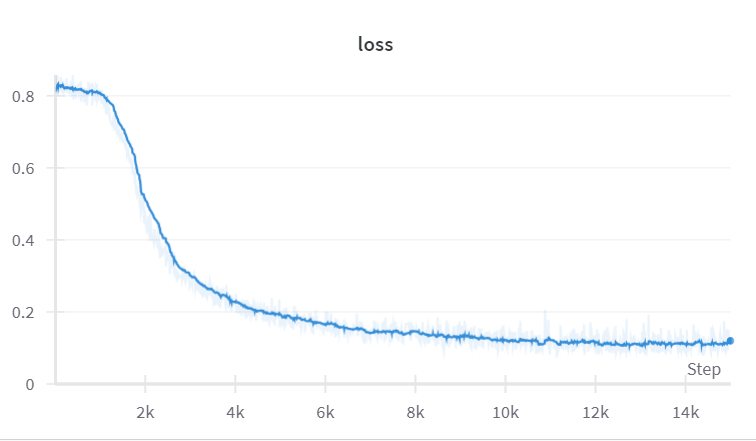